### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.tokenize import TweetTokenizer
from scipy.stats import beta, shapiro
from sklearn.model_selection import train_test_split

%matplotlib inline

SEED = 42

## Reading data

In [112]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.drop(['LocationRaw', 'SalaryRaw', 'SourceName', 'Id'], axis=1, inplace=True)
data.shape

(244768, 8)

In [117]:
data.head()

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,27500
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000


### Missing values 

In [114]:
data.isna().sum()

Title                      1
FullDescription            0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryNormalized           0
dtype: int64

In [115]:
text_columns = ["Title", "FullDescription"]
categorical_columns = [
    "Category",
    "Company",
    "LocationNormalized",
    "ContractType",
    "ContractTime",
]
target_column = "SalaryNormalized"

For now, let's just fill all the `NA` values with `NaN` 

In [79]:
data = data.fillna("NaN")

## Splitting data

In [80]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=SEED)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

data_train.shape, data_val.shape

((195814, 12), (48954, 12))

## Looking at data

In [81]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195814 entries, 0 to 195813
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  195814 non-null  int64 
 1   Title               195814 non-null  object
 2   FullDescription     195814 non-null  object
 3   LocationRaw         195814 non-null  object
 4   LocationNormalized  195814 non-null  object
 5   ContractType        195814 non-null  object
 6   ContractTime        195814 non-null  object
 7   Company             195814 non-null  object
 8   Category            195814 non-null  object
 9   SalaryRaw           195814 non-null  object
 10  SalaryNormalized    195814 non-null  int64 
 11  SourceName          195814 non-null  object
dtypes: int64(2), object(10)
memory usage: 17.9+ MB


#### Target

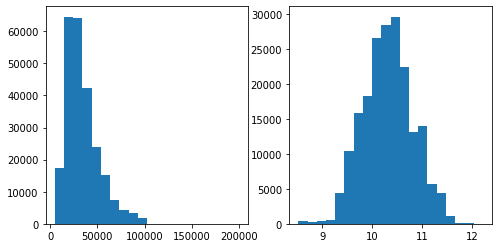

In [106]:
log1pSalary = np.log1p(data_train["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(log1pSalary, bins=20);

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc.

In [111]:
shapiro(log1pSalary)

ShapiroResult(statistic=0.9969059824943542, pvalue=2.802596928649634e-45)

#### Categorical columns

In [82]:
for cat_column in categorical_columns:
    print(f"'{cat_column}' column contains {data_train[cat_column].nunique()} unique values")

'Category' column contains 29 unique values
'Company' column contains 18857 unique values
'LocationNormalized' column contains 2543 unique values
'ContractType' column contains 3 unique values
'ContractTime' column contains 3 unique values


##### Category column

In [83]:
data_train["Category"].value_counts()

IT Jobs                             30847
Engineering Jobs                    20159
Accounting & Finance Jobs           17434
Healthcare & Nursing Jobs           16916
Sales Jobs                          13849
Other/General Jobs                  13567
Teaching Jobs                       10137
Hospitality & Catering Jobs          9066
Trade & Construction Jobs            7088
PR, Advertising & Marketing Jobs     7070
HR & Recruitment Jobs                6190
Admin Jobs                           6112
Retail Jobs                          5201
Customer Services Jobs               4794
Legal Jobs                           3145
Manufacturing Jobs                   3027
Logistics & Warehouse Jobs           2912
Social work Jobs                     2743
Consultancy Jobs                     2591
Travel Jobs                          2508
Scientific & QA Jobs                 2010
Charity & Voluntary Jobs             1867
Energy, Oil & Gas Jobs               1821
Creative & Design Jobs            

##### Company column

In [105]:
data_train["Company"].value_counts()

NaN                                                      25884
UKStaffsearch                                             4015
CVbrowser                                                 2387
London4Jobs                                               1859
Hays                                                      1424
                                                         ...  
Oxford University Hospitals NHS Trust                        1
Aspirations Care                                             1
MANPOWER UK LTD                                              1
Zolv.com Ltd                                                 1
The Facial Surgery Research Foundation   Saving Faces        1
Name: Company, Length: 18857, dtype: int64

##### LocationNormalized column

In [98]:
data_train["LocationNormalized"].value_counts()

UK                   32767
London               24483
South East London     9411
The City              5337
Manchester            2859
                     ...  
Kilbarchan               1
Brompton                 1
Kennoway                 1
Kirkby Stephen           1
Grimethorpe              1
Name: LocationNormalized, Length: 2543, dtype: int64

##### ContractType column

In [99]:
data_train["ContractType"].value_counts()

NaN          143245
full_time     46208
part_time      6361
Name: ContractType, dtype: int64

##### ContractTime column

In [100]:
data_train["ContractTime"].value_counts()

permanent    121042
NaN           51332
contract      23440
Name: ContractTime, dtype: int64

## Preparing

### Tokenizer

In [15]:
tokenizer = TweetTokenizer()
assert tokenizer.tokenize("I've been doing this for a few years!") == [
    "I've",
    "been",
    "doing",
    "this",
    "for",
    "a",
    "few",
    "years",
    "!",
]

## Dataset class

In [ ]:
class VacancyDataset:
    def __init__(self, data: pd.DataFrame, tokenizer, min_count=10, max_len=None):
        self.target = _preprocess_target(data)
        self.data = data.drop("SalaryNormalized", axis=1)

    def _preprocess_target(self, data: pd.DataFrame) -> np.array:
        target = np.log1p(data["SalaryNormalized"]).astype("float32")
        return target.values

    def _preprocess_data(self, data: pd.DataFrame):


        data[categorical_columns] = data[categorical_columns].fillna("NaN")

        description_lowercased_tokenized = data["FullDescription"].apply(
            lambda desc: " ".join(self.tokenizer.tokenize(str(desc).lower()))
        )
        title_lowercased = data["Title"].apply(
            lambda title: " ".join(self.tokenizer.tokenize(str(title).lower()))
        )
    def _encode_categorical(self):
        

In [32]:
from collections import Counter


In [ ]:
data["Company"]

In [33]:
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

# Questions

* Why did we use `max_len = 10` for `FullDescription` column?  
The text size in this column is so much bigger